## Preprocessing

In [22]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from keras.models import load_model
from keras_tuner import RandomSearch
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1, l2, l1_l2
from tensorflow.keras import layers


from keras_tuner import RandomSearch
from keras_tuner import BayesianOptimization
from keras_tuner import Hyperband
import keras_tuner as kt
import numpy as np
import matplotlib.pyplot as plt


#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [23]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [24]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(["EIN"], axis=1)

In [25]:
# Determine the number of unique values in each column.
application_df.nunique()

NAME                      19568
APPLICATION_TYPE             17
AFFILIATION                   6
CLASSIFICATION               71
USE_CASE                      5
ORGANIZATION                  4
STATUS                        2
INCOME_AMT                    9
SPECIAL_CONSIDERATIONS        2
ASK_AMT                    8747
IS_SUCCESSFUL                 2
dtype: int64

In [26]:
application_df["ASK_AMT"].value_counts()

ASK_AMT
5000        25398
10478           3
15583           3
63981           3
6725            3
            ...  
5371754         1
30060           1
43091152        1
18683           1
36500179        1
Name: count, Length: 8747, dtype: int64

In [27]:
# apply a logarithmic transformation to the ASK_AMT column
application_df["ASK_AMT"] = np.log10(application_df["ASK_AMT"])

In [28]:
# Count of name column
name_counts = application_df.NAME.value_counts()
name_counts

NAME
PARENT BOOSTER USA INC                                                  1260
TOPS CLUB INC                                                            765
UNITED STATES BOWLING CONGRESS INC                                       700
WASHINGTON STATE UNIVERSITY                                              492
AMATEUR ATHLETIC UNION OF THE UNITED STATES INC                          408
                                                                        ... 
ST LOUIS SLAM WOMENS FOOTBALL                                              1
AIESEC ALUMNI IBEROAMERICA CORP                                            1
WEALLBLEEDRED ORG INC                                                      1
AMERICAN SOCIETY FOR STANDARDS IN MEDIUMSHIP & PSYCHICAL INVESTIGATI       1
WATERHOUSE CHARITABLE TR                                                   1
Name: count, Length: 19568, dtype: int64

In [29]:
# Replace name values with counts less than 20 with "Other"
replace_application = list(name_counts[name_counts < 0.005*1260].index)

# Replace in dataframe
for name in replace_application:
    application_df.NAME = application_df.NAME.replace(name,"Other")

# Check to make sure binning was successful
application_df.NAME.value_counts()

NAME
Other                                          20277
PARENT BOOSTER USA INC                          1260
TOPS CLUB INC                                    765
UNITED STATES BOWLING CONGRESS INC               700
WASHINGTON STATE UNIVERSITY                      492
                                               ...  
RCI INC                                            7
MYTEAM TRIUMPH INC                                 7
NATIONAL ASSOCIATION OF CORPORATE DIRECTORS        7
CHRISTIAN MEDICAL & DENTAL SOCIETY                 7
NATIONAL KAPPA KAPPA IOTA INC                      7
Name: count, Length: 316, dtype: int64

In [30]:
# Look at APPLICATION_TYPE value counts for binning
application_df["APPLICATION_TYPE"].value_counts()

APPLICATION_TYPE
T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: count, dtype: int64

In [31]:
# Choose a cutoff value and create a list of application types to be replaced
# use the variable name `application_types_to_replace`
application_types_to_replace = ["T9", "T13", "T12", "T2", "T25", "T14", "T29", "T15", "T17"]

# Replace in dataframe
for app in application_types_to_replace:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(app,"Other")

# Check to make sure binning was successful
application_df['APPLICATION_TYPE'].value_counts()

APPLICATION_TYPE
T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: count, dtype: int64

In [32]:
# Look at CLASSIFICATION value counts for binning
application_df["CLASSIFICATION"].value_counts()

CLASSIFICATION
C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: count, Length: 71, dtype: int64

In [33]:
# You may find it helpful to look at CLASSIFICATION value counts >1
classification_counts = application_df["CLASSIFICATION"].value_counts()
test = classification_counts[classification_counts > 1]
test

CLASSIFICATION
C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
C1700      287
C4000      194
C5000      116
C1270      114
C2700      104
C2800       95
C7100       75
C1300       58
C1280       50
C1230       36
C1400       34
C7200       32
C2300       32
C1240       30
C8000       20
C7120       18
C1500       16
C1800       15
C6000       15
C1250       14
C8200       11
C1238       10
C1278       10
C1235        9
C1237        9
C7210        7
C2400        6
C1720        6
C4100        6
C1257        5
C1600        5
C1260        3
C2710        3
C0           3
C3200        2
C1234        2
C1246        2
C1267        2
C1256        2
Name: count, dtype: int64

In [34]:
#create a filter for binns to replace
filter = classification_counts[classification_counts < 1000].index.tolist()

In [35]:
# Choose a cutoff value and create a list of classifications to be replaced
# use the variable name `classifications_to_replace`

classifications_to_replace = filter

# Replace in dataframe
for cls in classifications_to_replace:
    application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(cls,"Other")
    
# Check to make sure binning was successful
application_df['CLASSIFICATION'].value_counts()

CLASSIFICATION
C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: count, dtype: int64

In [36]:
# Convert categorical data to numeric with `pd.get_dummies`
application_df = pd.get_dummies(application_df)

In [37]:
# Split our preprocessed data into our features and target arrays
y = application_df["IS_SUCCESSFUL"].values
X = application_df.drop(["IS_SUCCESSFUL"], axis=1).values

# Split the preprocessed data into a training and remaining datasets
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the preprocessed data into a validation and testing datasets
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)


In [38]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_val_scaled = X_scaler.transform(X_val)

In [39]:
X_train_scaled.shape

(27439, 359)

## Compile, Train and Evaluate the Model

In [40]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])

# Create a method that creates a new Sequential model with hyperparameter options
def build_model(hp, input_shape):

    model = tf.keras.models.Sequential()
    model.add(layers.Dense(units=hp.Int('units', min_value=50, max_value=200, step=10), activation='relu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l1(0.001)))

    # Tuning the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=10, max_value=200, step=10)
    

    model.add(layers.Dense(units=hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))

    model.add(layers.Dense(units=hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.001)))

    # Tuning the dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
    model.add(layers.Dropout(rate=hp_dropout))

    # Adding additional hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
        # Each hidden layer can have its own number of units and dropout rate
        layer_units = hp.Int(f'units_{i}', min_value=1, max_value=100, step=5)
        model.add(layers.Dense(units=layer_units, activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh'])))
        

    # Output layer
    model.add(layers.Dense(units=1, activation='sigmoid'))


    model.compile(optimizer='adam',
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model




In [41]:
input_shape = X_train_scaled.shape[1:]

early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Change to 'val_accuracy' if you care more about accuracy
    min_delta=0.01,      # Minimum change to qualify as an improvement
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='auto'          # 'auto' infers from the direction of the monitored metric
)

class AccuracyThresholdCallback(Callback):
    def __init__(self, threshold):
        super(AccuracyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get("accuracy")
        if accuracy is not None:
            if accuracy >= self.threshold:
                print(f"\nReached {self.threshold * 100}% accuracy, so stopping training!")
                self.model.stop_training = True

# Instantiate the callback with your desired threshold
accuracy_threshold = AccuracyThresholdCallback(threshold=0.85)


class PerformanceThresholdCallback(Callback):
    def __init__(self, threshold, patience=10):
        super(PerformanceThresholdCallback, self).__init__()
        self.threshold = threshold
        self.patience = patience
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get("accuracy")
        if accuracy is not None:
            if accuracy < self.threshold:
                self.wait += 1
                if self.wait >= self.patience:
                    print(f"\nAccuracy did not reach the threshold of {self.threshold * 100}% within {self.patience} epochs. Stopping training.")
                    self.model.stop_training = True
            else:
                self.wait = 0  # reset the counter if performance is good

# Instantiate the callback
performance_threshold = PerformanceThresholdCallback(threshold=0.72, patience=10)  

checkpoint_hyper = ModelCheckpoint(
    "checkpoints/hyper_weights.{epoch:02d}.hdf5",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None
)

checkpoint_bayesian = ModelCheckpoint(
    "checkpoints/bayesian_weights.{epoch:02d}.hdf5",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None
)

# Initialize the tuner
tuner1 = kt.Hyperband(
    lambda hp: build_model(hp, input_shape=input_shape),
    objective='val_accuracy',
    max_epochs=25,
    project_name='tuner0',
    hyperband_iterations=1
)


tuner2 = BayesianOptimization(
    lambda hp: build_model(hp, input_shape=input_shape),
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    project_name='tuner1'
)



Reloading Tuner from .\tuner0\tuner0.json


In [42]:
tuner1.search(X_train_scaled, y_train, 
             epochs=25,
             validation_data=(X_val_scaled, y_val),
             callbacks=[early_stopping, accuracy_threshold, performance_threshold, checkpoint_hyper]
             )

Trial 30 Complete [00h 00m 25s]
val_accuracy: 0.7883381843566895

Best val_accuracy So Far: 0.7921282649040222
Total elapsed time: 00h 08m 53s


In [43]:
tuner2.search(X_train_scaled, y_train, 
             epochs=25,
             validation_data=(X_val_scaled, y_val),
             callbacks=[early_stopping, accuracy_threshold, performance_threshold, checkpoint_bayesian]
             )

Trial 5 Complete [00h 01m 16s]
val_accuracy: 0.7895043690999349

Best val_accuracy So Far: 0.7895043690999349
Total elapsed time: 00h 06m 44s


In [44]:
# Get top 3 model hyperparameters and print the values
top_hyper1 = tuner1.get_best_hyperparameters(3)
for param in top_hyper1:
    print(param.values)

top_hyper2 = tuner2.get_best_hyperparameters(3)
for param in top_hyper2:
    print(param.values)

{'units': 180, 'dropout': 0.35000000000000003, 'num_layers': 2, 'units_0': 36, 'activation_0': 'relu', 'units_1': 6, 'activation_1': 'relu', 'units_2': 41, 'activation_2': 'tanh', 'units_3': 31, 'activation_3': 'tanh', 'units_4': 11, 'activation_4': 'relu', 'tuner/epochs': 25, 'tuner/initial_epoch': 9, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}
{'units': 110, 'dropout': 0.2, 'num_layers': 5, 'units_0': 11, 'activation_0': 'tanh', 'units_1': 56, 'activation_1': 'tanh', 'units_2': 56, 'activation_2': 'tanh', 'units_3': 16, 'activation_3': 'relu', 'units_4': 51, 'activation_4': 'tanh', 'tuner/epochs': 25, 'tuner/initial_epoch': 9, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0023'}
{'units': 180, 'dropout': 0.35000000000000003, 'num_layers': 2, 'units_0': 36, 'activation_0': 'relu', 'units_1': 6, 'activation_1': 'relu', 'units_2': 41, 'activation_2': 'tanh', 'units_3': 31, 'activation_3': 'tanh', 'units_4': 11, 'activation_4': 'relu', 'tuner/epochs': 9, 't

In [45]:
# Get best model hyperparameters
best_hyper1 = tuner1.get_best_hyperparameters(1)[0]
print(f" Hyperband values: {best_hyper1.values}")

best_hyper2 = tuner2.get_best_hyperparameters(1)[0]
print(f"Bayesian values: {best_hyper2.values}")

 Hyperband values: {'units': 180, 'dropout': 0.35000000000000003, 'num_layers': 2, 'units_0': 36, 'activation_0': 'relu', 'units_1': 6, 'activation_1': 'relu', 'units_2': 41, 'activation_2': 'tanh', 'units_3': 31, 'activation_3': 'tanh', 'units_4': 11, 'activation_4': 'relu', 'tuner/epochs': 25, 'tuner/initial_epoch': 9, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}
Bayesian values: {'units': 60, 'dropout': 0.05, 'num_layers': 5, 'units_0': 21, 'activation_0': 'relu', 'units_1': 76, 'activation_1': 'relu', 'units_2': 56, 'activation_2': 'tanh', 'units_3': 6, 'activation_3': 'tanh', 'units_4': 86, 'activation_4': 'relu'}


In [46]:
# Evaluate the top 3 models against the test dataset
top_model_1 = tuner1.get_best_models(3)
print("Hyperband:")
for model in top_model_1:
    model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

top_model_2 = tuner2.get_best_models(3)
print("Bayesian:")
for model in top_model_2:
    model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Hyperband:
108/108 - 0s - loss: 0.4983 - accuracy: 0.7822 - 382ms/epoch - 4ms/step
Loss: 0.49830305576324463, Accuracy: 0.7822157144546509
108/108 - 0s - loss: 0.4943 - accuracy: 0.7799 - 459ms/epoch - 4ms/step
Loss: 0.49428650736808777, Accuracy: 0.7798833847045898
108/108 - 0s - loss: 0.5099 - accuracy: 0.7810 - 420ms/epoch - 4ms/step
Loss: 0.5099402666091919, Accuracy: 0.7810495495796204
Bayesian:
108/108 - 0s - loss: 0.4922 - accuracy: 0.7828 - 426ms/epoch - 4ms/step
Loss: 0.4922061264514923, Accuracy: 0.7827988266944885
108/108 - 0s - loss: 0.5038 - accuracy: 0.7828 - 413ms/epoch - 4ms/step
Loss: 0.5038103461265564, Accuracy: 0.7827988266944885
108/108 - 0s - loss: 0.5035 - accuracy: 0.7784 - 448ms/epoch - 4ms/step
Loss: 0.503492534160614, Accuracy: 0.7784256339073181


Epoch 1/150
858/858 [==============================] - 3s 3ms/step - loss: 1.1337 - accuracy: 0.7727 - val_loss: 0.5819 - val_accuracy: 0.7778
Epoch 2/150
858/858 [==============================] - 2s 2ms/step - loss: 0.5392 - accuracy: 0.7828 - val_loss: 0.5302 - val_accuracy: 0.7755
Epoch 3/150
858/858 [==============================] - 2s 2ms/step - loss: 0.5036 - accuracy: 0.7870 - val_loss: 0.5084 - val_accuracy: 0.7805
Epoch 4/150
858/858 [==============================] - 2s 2ms/step - loss: 0.4911 - accuracy: 0.7880 - val_loss: 0.4970 - val_accuracy: 0.7732
Epoch 5/150
858/858 [==============================] - 2s 2ms/step - loss: 0.4857 - accuracy: 0.7878 - val_loss: 0.5035 - val_accuracy: 0.7685
Epoch 6/150
858/858 [==============================] - 2s 2ms/step - loss: 0.4825 - accuracy: 0.7885 - val_loss: 0.4866 - val_accuracy: 0.7810
Epoch 7/150
858/858 [==============================] - 2s 2ms/step - loss: 0.4780 - accuracy: 0.7892 - val_loss: 0.4808 - val_accuracy: 0.7805

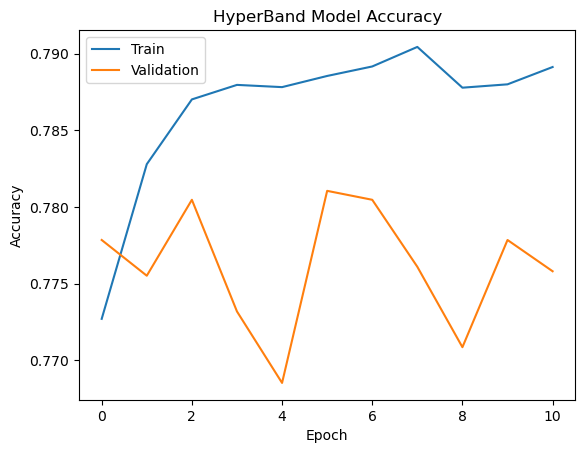

In [55]:
# train the best model using the hyper parameters found by the tuner to 150 epochs
hyper_model = build_model(best_hyper1, input_shape=input_shape)
hyper_history = hyper_model.fit(X_train_scaled, y_train, epochs=150, validation_data=(X_val_scaled, y_val), callbacks=[early_stopping, performance_threshold])
plt.plot(hyper_history.history['accuracy'])
plt.plot(hyper_history.history['val_accuracy'])
plt.title('HyperBand Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [56]:
# test the new model
model_loss, model_accuracy = hyper_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

108/108 - 0s - loss: 0.5059 - accuracy: 0.7735 - 153ms/epoch - 1ms/step
Loss: 0.5059400200843811, Accuracy: 0.7734693884849548


Epoch 1/150
858/858 [==============================] - 3s 3ms/step - loss: 0.7611 - accuracy: 0.7703 - val_loss: 0.5406 - val_accuracy: 0.7793
Epoch 2/150
858/858 [==============================] - 2s 2ms/step - loss: 0.5094 - accuracy: 0.7863 - val_loss: 0.4989 - val_accuracy: 0.7863
Epoch 3/150
858/858 [==============================] - 2s 2ms/step - loss: 0.4815 - accuracy: 0.7861 - val_loss: 0.4873 - val_accuracy: 0.7825
Epoch 4/150
858/858 [==============================] - 2s 2ms/step - loss: 0.4732 - accuracy: 0.7862 - val_loss: 0.4784 - val_accuracy: 0.7825
Epoch 5/150
858/858 [==============================] - 2s 2ms/step - loss: 0.4690 - accuracy: 0.7890 - val_loss: 0.4725 - val_accuracy: 0.7866
Epoch 6/150
858/858 [==============================] - 2s 2ms/step - loss: 0.4668 - accuracy: 0.7878 - val_loss: 0.4862 - val_accuracy: 0.7694
Epoch 7/150
858/858 [==============================] - 2s 2ms/step - loss: 0.4680 - accuracy: 0.7875 - val_loss: 0.4790 - val_accuracy: 0.7761

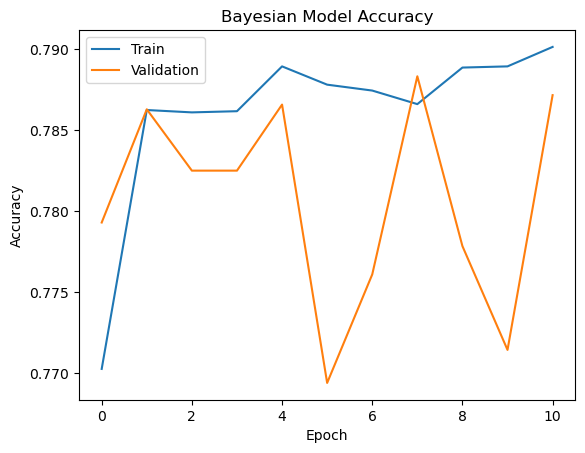

In [57]:
# train the best model using the hyper parameters found by the tuner to 150 epochs
bayesian_model = build_model(best_hyper2, input_shape=input_shape)
bayesian_history = bayesian_model.fit(X_train_scaled, y_train, epochs=150, validation_data=(X_val_scaled, y_val), callbacks=[early_stopping, performance_threshold])
plt.plot(bayesian_history.history['accuracy'])
plt.plot(bayesian_history.history['val_accuracy'])
plt.title('Bayesian Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [58]:
model_loss, model_accuracy = bayesian_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

108/108 - 0s - loss: 0.4895 - accuracy: 0.7810 - 170ms/epoch - 2ms/step
Loss: 0.48945945501327515, Accuracy: 0.7810495495796204


In [59]:
hyperband_top_1 = tuner1.get_best_models(1)[0]
hyperband_top_2 = tuner1.get_best_models(2)[1]
hyperband_top_3 = tuner1.get_best_models(3)[2]
#pretrained_model = load_model("AlphabetSoupCharity.h5")

bayesian_top_1 = tuner2.get_best_models(1)[0]
bayesian_top_2 = tuner2.get_best_models(2)[1]
bayesian_top_3 = tuner2.get_best_models(3)[2]

def ensemble_predictions(models, X):
    # Make predictions
    yhats = [model.predict(X) for model in models]
    yhats = np.array(yhats)
    # Average predictions
    avg_yhat = np.mean(yhats, axis=0)
    # Apply sigmoid
    predictions = np.round(avg_yhat)
    return predictions

models = [hyperband_top_1, hyperband_top_2, hyperband_top_3, bayesian_top_1, bayesian_top_2, bayesian_top_3]
y_pred = ensemble_predictions(models, X_test_scaled)
ensemble_accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble accuracy: {ensemble_accuracy}")



108/108 [==============================] - 0s 1ms/step
Ensemble accuracy: 0.7836734693877551


In [60]:
# Export our model to HDF5 file
bayesian_model.save("AlphabetSoupCharity_Optimized.h5")